In [46]:
import hyperloglog
import random
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

## One example

In [2]:
# Parameters
k = 32  # Number of HLL centers
m = 100000  # Total set size with multiplicities
p = 1000 # Total unique elements
precision = 0.01

In [3]:
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

# items = [random_string() for _ in range(m)]
pool = [random_string() for _ in range(p)]  # or any base size

# Sample m items from this pool with replacement
items = random.choices(pool, k=m)

### Get the estimate as if processing everything at one center

In [4]:
test_one_center = hyperloglog.HyperLogLog(precision)

In [5]:
for item in items:
    test_one_center.add(item)
one_center_cardinality = len(test_one_center)
print(f"Processing everything at one center: {one_center_cardinality}")

Processing everything at one center: 1007


### Processing at k different centers

In [6]:
# Create HLLs
centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]

In [7]:
check = {i:0 for i in range(k)}

In [8]:
# Assign each item to a random HLL
for item in items:
    center_idx = random.randint(0, k - 1)
    centers[center_idx].add(item)
    check[center_idx] += 1

In [9]:
# check

In [10]:
# # Optionally, inspect each center's estimate
# estimates = [len(center) for center in centers]
# for i, est in enumerate(estimates):
#     print(f"Center {i}: Estimated count = {est}")

# # Total estimated cardinality across all centers
# total_estimated = sum(estimates)
# print(f"\nSum of individual HLL estimates: {total_estimated}")
# print(f"Actual number of items: {m}")

In [21]:
coordinator = hyperloglog.HyperLogLog(precision)

In [22]:
num_iterations = int(math.log(k, 2))
number_bits = len(coordinator.M)
index = 0
bits = math.ceil(number_bits // num_iterations)

In [23]:
updated_centers = centers

In [41]:
def coordinator_processing(coordinator, index, updated_centers, bits, number_bits):
    for _ in range(num_iterations):
        # print(index)
        intermediate_M = [[0 for _ in range(0, index)] + center.M[index:min(index+bits,number_bits)] + [0 for _ in range(min(index+bits,number_bits),number_bits)] for center in updated_centers]

        for i in range(len(updated_centers)):
            coordinator.update_M(intermediate_M[i])
        
        top_half_indices = sorted(
            range(len(updated_centers)),
            key=lambda i: np.mean(centers[i].M[:min(index+bits,number_bits)]) if len(centers[i].M) >= 10 else -np.inf,
            reverse=True
        )[:len(updated_centers) // 2]

        updated_centers = [centers[i] for i in top_half_indices]
        
        # print(len(updated_centers))
        index = min(index+bits,number_bits)

    # distributed_cardinality = len(coordinator)
    # print(f"Processing in a distributed manner: {distributed_cardinality}")

In [27]:
coordinator_processing(coordinator, index, updated_centers)

0
16
3276
8
6552
4
9828
2
13104
1
Processing in a distributed manner: 1004


In [28]:
len(coordinator)

1004

In [15]:
print(f"The difference between the estimates of processing all the items at once center and in a distributed setting: {one_center_cardinality - distributed_cardinality}")

The difference between the estimates of processing all the items at once center and in a distributed setting: 3


### Ablation results
- Keep the number of distinct elements p and number of centers k constant and vary the set size m
- Keep the number of distinct elements p and set size m constant and vary the number of centers k
- k,m constant; p vary


## Multiple runs

### k constant p constant

In [42]:
# Parameters
k = 32  # Number of HLL centers
precision = 0.01
num_trials = 10
p = 1000 # Total unique elements
m_values = [500, 1000, 5000, 10000, 20000, 50000, 100000]

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [43]:
num_iterations = int(math.log(k, 2))

In [44]:
pool = [random_string() for _ in range(p)]  # or any base size

In [45]:
# Run experiment
results = []

for m in tqdm(m_values):
    for trial in range(num_trials):
        # items = [random_string() for _ in range(m)]
        # Sample m items from this pool with replacement
        items = random.choices(pool, k=m)

        # One-center estimate
        hll_one = hyperloglog.HyperLogLog(precision)
        for item in items:
            hll_one.add(item)
        one_center_est = len(hll_one)

        # Distributed estimate (merge later)
        centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
        for item in items:
            centers[random.randint(0, k - 1)].add(item)
        coordinator = hyperloglog.HyperLogLog(precision)
        
        updated_centers = centers
        number_bits = len(coordinator.M)
        index = 0
        bits = math.ceil(number_bits // num_iterations)
        
        coordinator_processing(coordinator, index, updated_centers, bits, number_bits)
        distributed_est = len(coordinator)

        # Store errors
        results.append({
            "m": m,
            "mode": "One Center",
            "abs_error": abs(one_center_est - p)
        })
        results.append({
            "m": m,
            "mode": "Distributed",
            "abs_error": abs(distributed_est - p)
        })
        
# Convert to DataFrame
df_m = pd.DataFrame(results)

In [47]:
# Filter to only 'Distributed' mode
df_dist = df_m[df_m["mode"] == "Distributed"]

In [48]:
df_dist

,m,mode,abs_error
1,500,Distributed,837
3,500,Distributed,826
5,500,Distributed,830
7,500,Distributed,831
9,500,Distributed,842
...,...,...,...
131,100000,Distributed,0
133,100000,Distributed,1
135,100000,Distributed,0
137,100000,Distributed,0


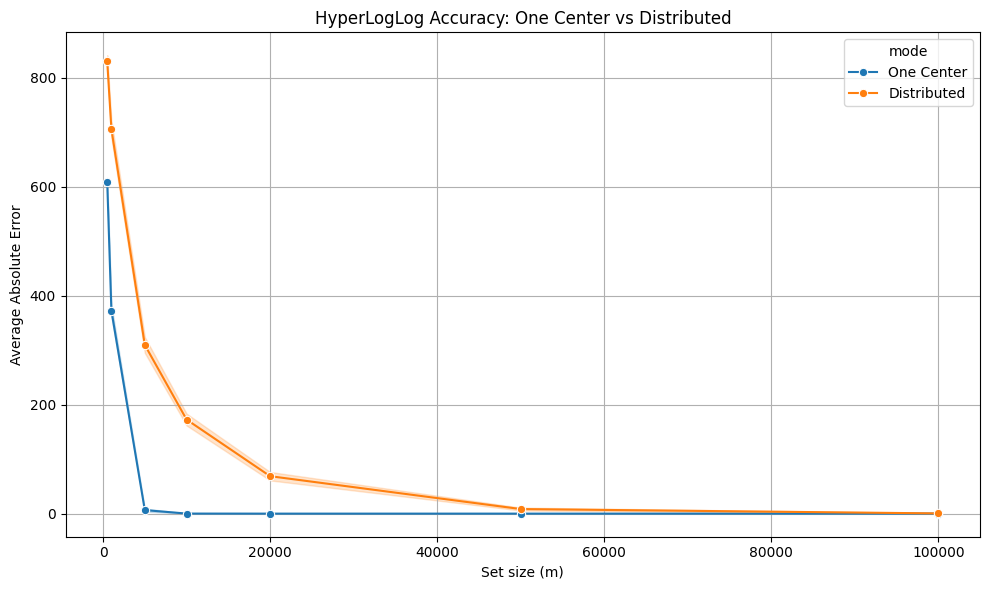

In [51]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Average Absolute Error"):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="m", y=y, hue="mode", marker="o", errorbar="sd")
    plt.title("HyperLogLog Accuracy: One Center vs Distributed")
    plt.xlabel("Set size (m)")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the updated plot
plot_distributed_and_one_center(df_m)

### k constant m constant

In [52]:
# Parameters
k = 32  # Number of HLL centers
precision = 0.01
num_trials = 10
m = 10000 # set size
p_values = [100, 500, 1000, 2000, 5000, 10000] # Total unique elements

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [ ]:
num_iterations = int(math.log(k, 2))

In [53]:
# # Experiment settings
# m = 10000
# k_values = [1, 2, 4, 8, 16, 32, 64]
# num_trials = 1
# precision = 0.01

# # Random string generator
# def random_string(length=30):
#     return ''.join(random.choices(string.ascii_letters, k=length))

In [54]:
# Run experiment
results_p = []

for p in tqdm(p_values):
    pool = [random_string() for _ in range(p)]
    for trial in range(num_trials):
        # items = [random_string() for _ in range(m)]
        # Sample m items from this pool with replacement
        items = random.choices(pool, k=m)

        # One-center estimate
        hll_one = hyperloglog.HyperLogLog(precision)
        for item in items:
            hll_one.add(item)
        one_center_est = len(hll_one)

        # Distributed estimate (merge later)
        centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
        for item in items:
            centers[random.randint(0, k - 1)].add(item)
        coordinator = hyperloglog.HyperLogLog(precision)
        
        updated_centers = centers
        number_bits = len(coordinator.M)
        index = 0
        bits = math.ceil(number_bits // num_iterations)
        
        coordinator_processing(coordinator, index, updated_centers, bits, number_bits)
        distributed_est = len(coordinator)

        # Store errors
        results.append({
            "p": p,
            "mode": "One Center",
            "abs_error": abs(one_center_est - p)
        })
        results.append({
            "p": p,
            "mode": "Distributed",
            "abs_error": abs(distributed_est - p)
        })
        
# Convert to DataFrame
df_p = pd.DataFrame(results)

100%|██████████| 6/6 [00:21<00:00,  3.65s/it]


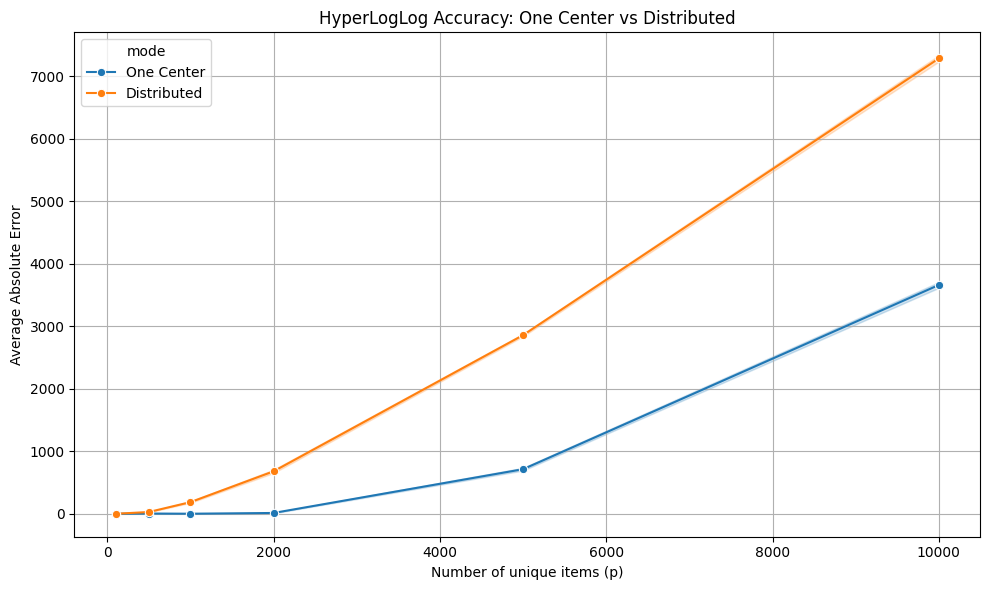

In [56]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Average Absolute Error"):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="p", y=y, hue="mode", marker="o", errorbar="sd")
    plt.title("HyperLogLog Accuracy: One Center vs Distributed")
    plt.xlabel("Number of unique items (p)")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the updated plot
plot_distributed_and_one_center(df_p)

### p constant m constant

In [64]:
# Parameters
precision = 0.01
num_trials = 10
m = 10000 # set size
p = 1000 # Number of unique items
k_values = [2, 4, 8, 16, 32, 64] # Total unique elements

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [65]:
# # Experiment settings
# m = 10000
# k_values = [1, 2, 4, 8, 16, 32, 64]
# num_trials = 1
# precision = 0.01

# # Random string generator
# def random_string(length=30):
#     return ''.join(random.choices(string.ascii_letters, k=length))

In [66]:
# Run experiment
results_k = []
pool = [random_string() for _ in range(p)]

for k in tqdm(k_values):
    num_iterations = int(math.log(k, 2))
    for trial in range(num_trials):
        # items = [random_string() for _ in range(m)]
        # Sample m items from this pool with replacement
        items = random.choices(pool, k=m)

        # One-center estimate
        hll_one = hyperloglog.HyperLogLog(precision)
        for item in items:
            hll_one.add(item)
        one_center_est = len(hll_one)

        # Distributed estimate (merge later)
        centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
        for item in items:
            centers[random.randint(0, k - 1)].add(item)
        coordinator = hyperloglog.HyperLogLog(precision)
        
        updated_centers = centers
        number_bits = len(coordinator.M)
        index = 0
        bits = math.ceil(number_bits // num_iterations)
        
        coordinator_processing(coordinator, index, updated_centers, bits, number_bits)
        distributed_est = len(coordinator)

        # Store errors
        results_k.append({
            "k": k,
            "mode": "One Center",
            "abs_error": abs(one_center_est - p)
        })
        results_k.append({
            "k": k,
            "mode": "Distributed",
            "abs_error": abs(distributed_est - p)
        })
        
# Convert to DataFrame
df_k = pd.DataFrame(results_k)

100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


In [67]:
df_k

,k,mode,abs_error
0,2,One Center,0
1,2,Distributed,0
2,2,One Center,0
3,2,Distributed,0
4,2,One Center,0
...,...,...,...
115,64,Distributed,265
116,64,One Center,0
117,64,Distributed,262
118,64,One Center,0


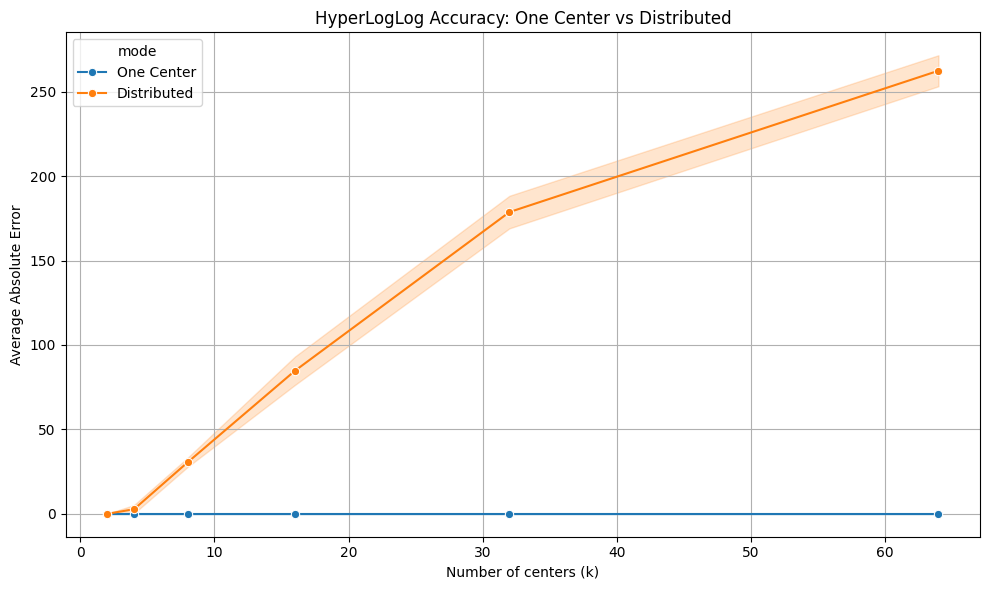

In [68]:
def plot_distributed_and_one_center(df, y="abs_error", ylabel="Average Absolute Error"):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="k", y=y, hue="mode", marker="o", errorbar="sd")
    plt.title("HyperLogLog Accuracy: One Center vs Distributed")
    plt.xlabel("Number of centers (k)")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the updated plot
plot_distributed_and_one_center(df_k)